In [1]:
!pip install --user -q ktext
!pip install --user  -q annoy
!pip install --user  tensorflow_hub

     |████████████████████████████████| 143kB 10.4MB/s 
     |████████████████████████████████| 163kB 18.4MB/s 
     |████████████████████████████████| 317kB 9.6MB/s 
     |████████████████████████████████| 51kB 5.3MB/s 
     |████████████████████████████████| 481kB 25.0MB/s 
     |████████████████████████████████| 245kB 26.2MB/s 
     |████████████████████████████████| 102kB 12.5MB/s 
     |████████████████████████████████| 51kB 7.1MB/s 
     |████████████████████████████████| 3.0MB 33.3MB/s 
     |████████████████████████████████| 71kB 9.9MB/s 
     |████████████████████████████████| 112kB 54.8MB/s 
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
     |████████████████████████████████| 645kB 7.6MB/s 


In [5]:
!pip install annoy

In [0]:
import json
from urllib.request import urlopen

from annoy import AnnoyIndex
from tensorflow.python.keras.layers import Input, Dense, LSTM, GRU, Embedding, Lambda, BatchNormalization
from tensorflow.python.keras.models import load_model, Model
from tensorflow.python.keras import optimizer
from tensorflow.python.keras.preprocessing.sequence import pad_sequences
from keras.utils import get_file, to_categorical
from ktext.preprocess import processor
import numpy as np
import pandas as pd
import random
from tqdm import tqdm

In [0]:
# get training data

# data = pd.read_csv('final_recipes.csv')
data = pd.read_csv('final_two.csv')
# data = data.replace(to_replace= ["[","'","]"], value= '', regex=True)


In [0]:
data.dropna(inplace=True)
data['ingredients'] = data['ingredients'].apply(lambda x: x.replace("[","").replace("'","").replace("]","").replace(" , ","").replace(",,,,,,","").replace(",,","").replace(",,,","").replace(",,,,","").replace(",,,,,",""))
data['name'] = data['name'].apply(lambda x: x.replace('  ',' ').replace('  ',' '))

In [5]:
data['name'].head(40)

0              arriba baked winter squash mexican style
1                       a bit different breakfast pizza
2                              all in the kitchen chili
3                                     alouette potatoes
4                      amish tomato ketchup for canning
5                                apple a day milk shake
6                                  aww marinated olives
7                         backyard style barbecued ribs
8                               bananas 4 ice cream pie
9                                beat this banana bread
10                           berry good sandwich spread
11                         better than sex strawberries
12                       better then bush s baked beans
13                            boat house collard greens
14                               calm your nerves tonic
15                       chicken lickin good pork chops
16                                       chile rellenos
17                                        chines

In [0]:
from sklearn.model_selection import train_test_split

#target - recipe name
#source = ingredients
source_docs = data['ingredients'].tolist()
target_docs = data['name'].tolist()

# source_docs_t = data['ingredients'].sample(2000, random_state=7).tolist()
# target_docs_t = data['name'].sample(2000, random_state=7).tolist()

train_source_docs, test_source_docs, train_target_docs, test_target_docs = train_test_split(source_docs, target_docs, test_size=0.33, random_state=42)

for i in range(len(train_source_docs)):
    train_source_docs[i] = train_source_docs[i].replace("'","").replace("  "," ").replace("[","").replace("]","").replace(" ,","")

test_docs = pd.Series(test_target_docs).sample(10000).tolist()



In [0]:
# len(test_docs)
# test_docs
# train_source_docs
# train_target_docs

In [8]:
#processor adds padding to all text entries in order to make all inputs the same length
proc = processor(heuristic_pct_padding=.95, keep_n=10000)
vecs = proc.fit_transform(target_docs)



 See full histogram by insepecting the `document_length_stats` attribute.


In [0]:
# proc.token_count_pandas().head(20)

In [10]:
proc.document_length_stats

,bin,doc_count,cumsum_pct
1,0,25419,0.109737
0,5,191905,0.938213
2,10,14253,0.999745
3,15,59,1.000000


In [0]:
assert vecs.shape[0] == len(target_docs)

In [12]:
print('original list: ', target_docs[0])
print('tokenized list: ', vecs[0])

original list:  arriba baked winter squash mexican style
tokenized list:  [   0    0    0    0 7897   22  587  121  106   45]


In [13]:
vocab_size = max(proc.id2token.keys()) + 1
max_length = proc.padding_maxlen

print('vocab size: ', vocab_size)
print('max length allowed for documents: ', max_length)

vocab size:  10002
max length allowed for documents:  10


In [14]:
sequences = []
for arr in tqdm(vecs):
    non_zero = (arr != 0).argmax()
    for i in range(non_zero, len(arr)):
        sequences.append(arr[:i+1])
sequences = pad_sequences(sequences, maxlen=max_length, padding='pre')
sequences = np.array(sequences)
X, y = sequences[:,:-1], sequences[:,-1]
# y = to_categorical(y, num_classes=vocab_size)

100%|██████████| 231636/231636 [00:01<00:00, 225069.32it/s]


In [15]:
i = Input(shape=(max_length-1,))
x = Embedding(vocab_size, 256, input_length=max_length-1)(i)
x = LSTM(256, return_sequences=True)(x)
last_timestep = Lambda(lambda x: x[:, -1, :])(x)
last_timestep = Dense(vocab_size, activation='softmax')(last_timestep)
model = Model(i, last_timestep)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 9)]               0         
_________________________________________________________________
embedding (Embedding)        (None, 9, 256)            2560512   
_________________________________________________________________
lstm (LSTM)                  (None, 9, 256)            525312    
_________________________________________________________________
lambda (Lambda)              (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 10002)             2570514   
Total params: 5,656,338
Trainable params: 5,656,338
Non-trainable params: 0
_________________________________________________________________


In [16]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X, y, epochs=15, batch_size=256, validation_split=0.2)

Epoch 1/15
3162/3162 [==============================] - 110s 35ms/step - loss: 5.9032 - accuracy: 0.1255 - val_loss: 6.3126 - val_accuracy: 0.1560
Epoch 2/15
3162/3162 [==============================] - 106s 34ms/step - loss: 5.2054 - accuracy: 0.1845 - val_loss: 6.2665 - val_accuracy: 0.1786
Epoch 3/15
3162/3162 [==============================] - 106s 34ms/step - loss: 4.9643 - accuracy: 0.2000 - val_loss: 6.3648 - val_accuracy: 0.1838
Epoch 4/15
3162/3162 [==============================] - 107s 34ms/step - loss: 4.8068 - accuracy: 0.2096 - val_loss: 6.3939 - val_accuracy: 0.1866
Epoch 5/15
3162/3162 [==============================] - 107s 34ms/step - loss: 4.6867 - accuracy: 0.2170 - val_loss: 6.5207 - val_accuracy: 0.1886
Epoch 6/15
3162/3162 [==============================] - 107s 34ms/step - loss: 4.5870 - accuracy: 0.2236 - val_loss: 6.5653 - val_accuracy: 0.1874
Epoch 7/15
3162/3162 [==============================] - 106s 34ms/step - loss: 4.5002 - accuracy: 0.2300 - val_loss: 6

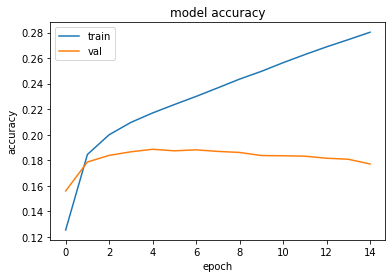

In [20]:
from matplotlib import pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [0]:
def generate_seq(model, proc, n_words, seed_text):
    in_text = seed_text
    for _ in range(n_words):
        vec = proc.transform([in_text])[:,1:]
        index = np.argmax(model.predict(vec, verbose=0), axis=1)[0]
        out_word = ''
        if index == 1:
            out_word = '_unk_'
        else:
            out_word = proc.id2token[index]
        in_text += ' ' + out_word
    return in_text

In [22]:
generate_seq(model, proc, max_length, 'cold')

'cold cucumber and radish salad with lime dressing dressing salad salad'

In [0]:
embedding_model = Model(inputs=model.inputs, outputs=model.layers[-3].output)
import tensorflow as tf
# import tensorflow_hub as hub

#using goolge embeddings
# embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")


In [0]:
# embedding_model = embed(Model(inputs=model.inputs, outputs=model.layers[-3].output))

In [25]:
input_sequence = test_docs[random.randint(0, len(test_docs))]
print('input sequence: ', input_sequence, '\n\nhidden states:\n')
vec = proc.transform([input_sequence])[:,1:]
embedding_model.predict(vec)

input sequence:  greek country chicken 

hidden states:



array([[[-5.42407681e-04,  6.79876626e-01, -6.25794637e-05, ...,
         -4.59693978e-03, -5.75528204e-01,  1.30559877e-02],
        [-2.56459498e-05,  5.66342711e-01, -4.34591101e-07, ...,
         -2.33814735e-05, -7.82317761e-03, -1.34587707e-03],
        [-2.72134512e-05,  8.61239731e-01, -9.25380959e-07, ...,
         -8.50662618e-05, -7.37224892e-03, -1.27710449e-03],
        ...,
        [-1.19688184e-06,  2.14657299e-02, -1.39537747e-06, ...,
         -2.58620867e-06, -2.99489126e-03, -1.19166132e-02],
        [-1.22945441e-03,  1.17683625e-02, -2.97509786e-03, ...,
         -2.38019181e-03, -1.72720514e-02, -9.95290279e-01],
        [-9.29809563e-11,  5.44131435e-05, -1.45661124e-05, ...,
         -8.28980592e-06, -8.71996939e-01, -3.08233539e-05]]],
      dtype=float32)

In [0]:
test_vecs = proc.transform(test_docs)

In [0]:
hidden_states = embedding_model.predict(test_vecs[:, 1:])

In [0]:
mean_vecs = np.mean(hidden_states, axis=1)
max_vecs = np.max(hidden_states, axis=1)
sum_vecs = np.sum(hidden_states, axis=1)

In [29]:
dimension = hidden_states.shape[-1]
index = AnnoyIndex(dimension)
for i, v in enumerate(sum_vecs):
    index.add_item(i, v)
index.build(10)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: The default argument for metric will be removed in future version of Annoy. Please pass metric='angular' explicitly.
  


True

In [30]:
input_sequence = test_docs[random.randint(0, len(test_docs))]
print('Query: ', input_sequence)

vec = proc.transform([input_sequence])[:,1:]
vec = np.sum(embedding_model.predict(vec), axis=1)
ids, _ = index.get_nns_by_vector(vec.T, 10, include_distances=True)

print('\nSearch Results:')
[test_docs[i] for i in ids][1:]

Query:  crack dip

Search Results:


['incredible omelet',
 'favorite brownies',
 'gooey rolls',
 'creole cake',
 'best burgers',
 'classic blondies',
 'bisquick shortcakes',
 'good sandwich',
 'baked cheesecake']

In [31]:
source_proc = processor(heuristic_pct_padding=.95, keep_n=50000)
source_vecs = source_proc.fit_transform(source_docs)

 See full histogram by insepecting the `document_length_stats` attribute.


In [32]:
target_proc = processor(append_indicators=True, heuristic_pct_padding=.95, keep_n=12000, padding ='post')
target_vecs = target_proc.fit_transform(target_docs)

 See full histogram by insepecting the `document_length_stats` attribute.


In [0]:
encoder_input_data = source_vecs
encoder_seq_len = encoder_input_data.shape[1]

decoder_input_data = target_vecs[:, :-1]
decoder_target_data = target_vecs[:, 1:]

num_encoder_tokens = max(source_proc.id2token.keys()) + 1
num_decoder_tokens = max(target_proc.id2token.keys()) + 1

In [0]:
#Create encoder

In [0]:
word_emb_dim=512
hidden_state_dim=1024
encoder_seq_len=encoder_seq_len
num_encoder_tokens=num_encoder_tokens
num_decoder_tokens=num_decoder_tokens

encoder_inputs = Input(shape=(encoder_seq_len,), name='Encoder-Input')
x = Embedding(num_encoder_tokens, word_emb_dim, name='Body-Word-Embedding', mask_zero=False)(encoder_inputs)
x = BatchNormalization(name='Encoder-Batchnorm-1')(x)
_, state_h = GRU(hidden_state_dim, return_state=True, name='Encoder-Last-GRU', dropout=.5)(x)
encoder_model = Model(inputs=encoder_inputs, outputs=state_h, name='Encoder-Model')
seq2seq_encoder_out = encoder_model(encoder_inputs)

In [36]:
encoder_model.summary()

Model: "Encoder-Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Encoder-Input (InputLayer)   [(None, 30)]              0         
_________________________________________________________________
Body-Word-Embedding (Embeddi (None, 30, 512)           2163712   
_________________________________________________________________
Encoder-Batchnorm-1 (BatchNo (None, 30, 512)           2048      
_________________________________________________________________
Encoder-Last-GRU (GRU)       [(None, 1024), (None, 102 4724736   
Total params: 6,890,496
Trainable params: 6,889,472
Non-trainable params: 1,024
_________________________________________________________________


In [0]:
decoder_inputs = Input(shape=(None,), name='Decoder-Input')
dec_emb = Embedding(num_decoder_tokens, word_emb_dim, name='Decoder-Word-Embedding', mask_zero=False)(decoder_inputs)
dec_bn = BatchNormalization(name='Decoder-Batchnorm-1')(dec_emb)
decoder_gru = GRU(hidden_state_dim, return_state=True, return_sequences=True, name='Decoder-GRU', dropout=.5)
decoder_gru_output, _ = decoder_gru(dec_bn, initial_state=seq2seq_encoder_out)
x = BatchNormalization(name='Decoder-Batchnorm-2')(decoder_gru_output)
decoder_dense = Dense(num_decoder_tokens, activation='softmax', name='Final-Output-Dense')
decoder_outputs = decoder_dense(x)

In [0]:
seq2seq_model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [39]:
seq2seq_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Decoder-Input (InputLayer)      [(None, None)]       0                                            
__________________________________________________________________________________________________
Decoder-Word-Embedding (Embeddi (None, None, 512)    6145024     Decoder-Input[0][0]              
__________________________________________________________________________________________________
Encoder-Input (InputLayer)      [(None, 30)]         0                                            
__________________________________________________________________________________________________
Decoder-Batchnorm-1 (BatchNorma (None, None, 512)    2048        Decoder-Word-Embedding[0][0]     
____________________________________________________________________________________________

In [43]:
# from keras import optimizers
# model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
batch_size = 512
epochs = 15
#i upped the learning rate by x10,see how that works, its at 21% acc at epoch 5 elsewise
# seq2seq_model.compile(optimizer=optimizers.Nadam(lr=0.0005), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
seq2seq_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = seq2seq_model.fit([encoder_input_data, decoder_input_data],
                            np.expand_dims(decoder_target_data, -1),
                            batch_size=batch_size,
                            epochs=epochs,
                            validation_split=0.1)

Epoch 1/15
408/408 [==============================] - 165s 405ms/step - loss: 2.3158 - accuracy: 0.6261 - val_loss: 9.0808 - val_accuracy: 0.1316
Epoch 2/15
408/408 [==============================] - 167s 408ms/step - loss: 1.6608 - accuracy: 0.6783 - val_loss: 2.3518 - val_accuracy: 0.6333
Epoch 3/15
408/408 [==============================] - 166s 407ms/step - loss: 1.4554 - accuracy: 0.6964 - val_loss: 2.3974 - val_accuracy: 0.6364
Epoch 4/15
408/408 [==============================] - 167s 409ms/step - loss: 1.3166 - accuracy: 0.7118 - val_loss: 2.4636 - val_accuracy: 0.6363
Epoch 5/15
408/408 [==============================] - 166s 407ms/step - loss: 1.2136 - accuracy: 0.7252 - val_loss: 2.5169 - val_accuracy: 0.6362
Epoch 6/15
408/408 [==============================] - 166s 408ms/step - loss: 1.1291 - accuracy: 0.7372 - val_loss: 2.5795 - val_accuracy: 0.6337
Epoch 7/15
408/408 [==============================] - 167s 409ms/step - loss: 1.0572 - accuracy: 0.7482 - val_loss: 2.6580 -

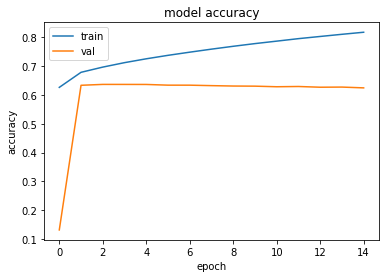

In [44]:
from matplotlib import pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [0]:
# !wget https://storage.googleapis.com/kdd-seq2seq-2018/kdd_seq2seq_weights.h5

In [0]:
# seq2seq_model.load_weights('kdd_seq2seq_weights.h5')

In [0]:
def extract_decoder_model(model):
    latent_dim = model.get_layer('Encoder-Model').output_shape[-1]
    decoder_inputs = model.get_layer('Decoder-Input').input
    dec_emb = model.get_layer('Decoder-Word-Embedding')(decoder_inputs)
    dec_bn = model.get_layer('Decoder-Batchnorm-1')(dec_emb)
    gru_inference_state_input = Input(shape=(latent_dim,), name='hidden_state_input')
    gru_out, gru_state_out = model.get_layer('Decoder-GRU')([dec_bn, gru_inference_state_input])
    dec_bn2 = model.get_layer('Decoder-Batchnorm-2')(gru_out)
    dense_out = model.get_layer('Final-Output-Dense')(dec_bn2)
    decoder_model = Model([decoder_inputs, gru_inference_state_input], [dense_out, gru_state_out])
    return decoder_model

In [47]:
encoder_model = seq2seq_model.get_layer('Encoder-Model')
for layer in encoder_model.layers:
    layer.trainable = False

decoder_model = extract_decoder_model(seq2seq_model)
decoder_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Decoder-Input (InputLayer)      [(None, None)]       0                                            
__________________________________________________________________________________________________
Decoder-Word-Embedding (Embeddi (None, None, 512)    6145024     Decoder-Input[0][0]              
__________________________________________________________________________________________________
Decoder-Batchnorm-1 (BatchNorma (None, None, 512)    2048        Decoder-Word-Embedding[1][0]     
__________________________________________________________________________________________________
hidden_state_input (InputLayer) [(None, 1024)]       0                                            
____________________________________________________________________________________________

In [48]:
i = random.randint(0, len(test_source_docs))

max_len = target_proc.padding_maxlen
raw_input_text = test_source_docs[i]

raw_tokenized = source_proc.transform([raw_input_text])
encoding = encoder_model.predict(raw_tokenized)
original_encoding = encoding
state_value = np.array(target_proc.token2id['_start_']).reshape(1, 1)

decoded_sentence = []
stop_condition = False
while not stop_condition:
    preds, st = decoder_model.predict([state_value, encoding])
    pred_idx = np.argmax(preds[:, :, 2:]) + 2
    pred_word_str = target_proc.id2token[pred_idx]

    if pred_word_str == '_end_' or len(decoded_sentence) >= max_len:
        stop_condition = True
        break
    decoded_sentence.append(pred_word_str)

    # update the decoder for the next word
    encoding = st
    state_value = np.array(pred_idx).reshape(1, 1)

print('sample code from test set:\n------------------------\n', raw_input_text)
print('\nground truth:\n------------------------\n', test_target_docs[i])
print('\npredicted description:\n------------------------')
print(' '.join(decoded_sentence))

sample code from test set:
------------------------
 frozen chopped spinach, salted butter, fresh garlic, onions, flour, heavy cream, fresh lemon juice, pecorino romano cheese, sour cream, sharp white cheddar cheese, mozzarella cheese

ground truth:
------------------------
 your last spinach dip recipe

predicted description:
------------------------
paula deen s spinach and cheese casserole


In [0]:
#generate embeddings

In [0]:
train_source_emb = encoder_model.predict(source_proc.transform(source_docs))

In [0]:
train_target_vecs = proc.transform(target_docs)
hidden_states = embedding_model.predict(train_target_vecs[:, 1:])

In [0]:
mean_vecs = np.mean(hidden_states, axis=1)
max_vecs = np.max(hidden_states, axis=1)
sum_vecs = np.sum(hidden_states, axis=1)
# train_target_emb = mean_vecs
train_target_emb = max_vecs

In [53]:
print('source embedding shape on training set: ', train_source_emb.shape)
print('target embedding shape on training set: ', train_target_emb.shape)

source embedding shape on training set:  (231636, 1024)
target embedding shape on training set:  (231636, 256)


In [54]:
dimension = hidden_states.shape[-1]
index = AnnoyIndex(dimension)
for i, v in enumerate(sum_vecs):
    index.add_item(i, v)
index.build(10)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: The default argument for metric will be removed in future version of Annoy. Please pass metric='angular' explicitly.
  


True

In [0]:
#create joint vector space for embeddings

In [56]:
inp = Input(shape=(train_source_emb.shape[1],))
x = Dense(train_target_emb.shape[1], use_bias=False)(inp)
# x = BatchNormalization()(x)
# x = Dense(train_target_emb.shape[1])(x)
modal_model = Model([inp], x)
modal_model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 1024)]            0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               262144    
Total params: 262,144
Trainable params: 262,144
Non-trainable params: 0
_________________________________________________________________


In [61]:
# modal_model.compile(optimizer=optimizers.Nadam(lr=2), loss='cosine_proximity', metrics=['accuracy'])
modal_model.compile(optimizer = 'adam', loss='cosine_similarity', metrics=['accuracy'])
batch_size = 512
epochs = 50
history = modal_model.fit([train_source_emb], train_target_emb,
                          batch_size=batch_size, epochs=epochs, validation_split=0.1)

Epoch 1/50
408/408 [==============================] - 2s 5ms/step - loss: -0.8544 - accuracy: 0.0364 - val_loss: -0.8709 - val_accuracy: 0.0452
Epoch 2/50
408/408 [==============================] - 2s 4ms/step - loss: -0.8788 - accuracy: 0.0485 - val_loss: -0.8730 - val_accuracy: 0.0491
Epoch 3/50
408/408 [==============================] - 2s 4ms/step - loss: -0.8807 - accuracy: 0.0525 - val_loss: -0.8738 - val_accuracy: 0.0516
Epoch 4/50
408/408 [==============================] - 2s 4ms/step - loss: -0.8814 - accuracy: 0.0546 - val_loss: -0.8740 - val_accuracy: 0.0500
Epoch 5/50
408/408 [==============================] - 2s 4ms/step - loss: -0.8818 - accuracy: 0.0564 - val_loss: -0.8741 - val_accuracy: 0.0519
Epoch 6/50
408/408 [==============================] - 2s 4ms/step - loss: -0.8820 - accuracy: 0.0573 - val_loss: -0.8742 - val_accuracy: 0.0515
Epoch 7/50
408/408 [==============================] - 2s 4ms/step - loss: -0.8821 - accuracy: 0.0581 - val_loss: -0.8742 - val_accuracy:

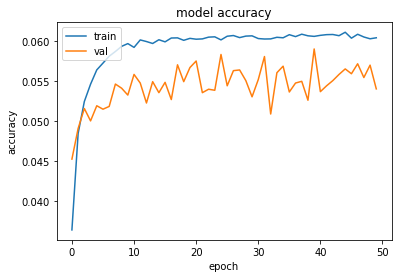

In [64]:
from matplotlib import pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [65]:
vec_code = modal_model.predict(encoder_model.predict(source_proc.transform(source_docs)))
vec_code.shape

(231636, 256)

In [66]:
#all code in a search box
dimension = vec_code.shape[-1]
index = AnnoyIndex(dimension)
for i, v in enumerate(vec_code):
    index.add_item(i, v)
index.build(10)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: FutureWarning: The default argument for metric will be removed in future version of Annoy. Please pass metric='angular' explicitly.
  This is separate from the ipykernel package so we can avoid doing imports until


True

In [0]:
def vectorize_string(txt):
  vec = proc.transform([txt])[:,1:]
  emb = np.mean(embedding_model.predict(vec), axis=1)
  return emb

In [0]:
def search(inp):
  inp = vectorize_string(inp)
  ids, dist = index.get_nns_by_vector(inp.squeeze(), 5, include_distances=True)

  for i, dist in zip(ids, dist):
    print(f'dist: {dist:.2f}\n{source_docs[i]}\n')

In [0]:
# search('read csv file into pandas dataframe')

In [70]:
 search('chicken pot pie')

dist: 1.02
boneless skinless chicken breasts, margarine, water, ritz cracker crumbs, parmesan cheese, cream of chicken soup, sour cream, mushrooms

dist: 1.02
chicken fat, onions, carrot, celery, green pepper, apple, chicken broth, all-purpose flour, canned tomato, salt, pepper, curry powder, cooked chicken

dist: 1.03
boneless skinless chicken breasts, "aunt janes krazy mixed up salt", olive oil, onion, cream of mushroom soup, cream of chicken soup, sour cream, ritz cracker, butter

dist: 1.03
milk, flour, cream of mushroom soup, dry onion soup mix, margarine, chicken

dist: 1.03
chicken breasts, mushroom soup, white wine, milk, pepperidge farm stuffing



In [71]:
 search('iced tea')

dist: 1.02
limoncello, vodka, cranberry juice

dist: 1.02
cranberries, vodka

dist: 1.03
triple sec, grand marnier, light rum, orange juice, creme de almond

dist: 1.03
vodka, pomegranate liqueur, unsweetened cranberry juice

dist: 1.03
rum, chambord raspberry liquor, apple juice



In [72]:
 search('chocolate chip cookie')

dist: 1.00
butter, graham cracker crumbs, sweetened condensed milk, butterscotch chips, semi-sweet chocolate chips, flaked coconut, nuts

dist: 1.01
graham cracker crumbs, butter, sweetened condensed milk, semi-sweet chocolate chips, milk chocolate chips, vanilla extract, pecans

dist: 1.01
butter, graham cracker crumbs, coconut, butterscotch chips, semi-sweet chocolate chips, sweetened condensed milk, nuts

dist: 1.01
butter, graham crackers, chocolate chips, butterscotch chips, coconut, walnuts, condensed milk

dist: 1.01
butter, graham wafer crumbs, sweetened flaked coconut, chocolate chips, butterscotch chips, sweetened condensed milk, walnuts

